<a href="https://colab.research.google.com/github/Eric-Chung-0511/Learning-Record/blob/main/General%20Helpers/PyTorch/Experiments/PyTorch_Replicate_Papers_Eric.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !mv pytorch-deep-learning/helper_functions.py . # get the helper_functions.py script
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves

[INFO] Couldn't find torchinfo... installing it.
[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.
Cloning into 'pytorch-deep-learning'...
remote: Enumerating objects: 4177, done.
remote: Counting objects: 100% (142/142), done.
remote: Compressing objects: 100% (102/102), done.
remote: Total 4177 (delta 62), reused 103 (delta 39), pack-reused 4035 (from 1)
Receiving objects: 100% (4177/4177), 651.42 MiB | 35.39 MiB/s, done.
Resolving deltas: 100% (2433/2433), done.
Updating files: 100% (248/248), done.


In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

## 1. Get Data

In [3]:
# Download pizza, steak, sushi images from GitHub
image_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                           destination="pizza_steak_sushi")
image_path

[INFO] Did not find data/pizza_steak_sushi directory, creating one...
[INFO] Downloading pizza_steak_sushi.zip from https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip...
[INFO] Unzipping pizza_steak_sushi.zip data...


PosixPath('data/pizza_steak_sushi')

In [4]:
# Setup directory paths to train and test images
train_dir = image_path / 'train'
test_dir = image_path / 'test'

## 2. Create Datasets and DataLoaders

### 2.1 Prepare transforms for images

In [5]:
# create image size
IMG_SIZE = 224

manual_transforms = transforms.Compose([transforms.Resize((IMG_SIZE, IMG_SIZE)),
                                        transforms.ToTensor()])

print(f"Manually created transforms: {manual_transforms}")

Manually created transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
)


### 2.2 Turn images into DataLoader's

In [6]:
BATCH_SIZE = 32

# create dataloaders
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                               test_dir=test_dir,
                                                                               transform=manual_transforms,
                                                                               batch_size=BATCH_SIZE)

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7988a5251690>,
 ['pizza', 'steak', 'sushi'])

### 2.3 Visualize a single image

In [7]:
# Get a batch of images
image_batch, label_batch = next(iter(train_dataloader))

# Get a single fro, batch
image, label = image_batch[0], label_batch[0]

# View the batch shapes
image.shape, label

(torch.Size([3, 224, 224]), tensor(1))

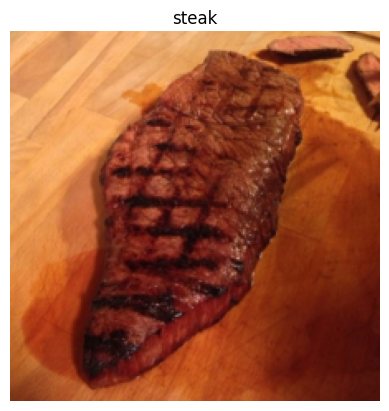

In [8]:
# plot with matplotlib
# if not using .permute(1, 2, 0) will cause TypeError: Invalid shape (3, 224, 224) for image data
plt.imshow(image.permute(1, 2, 0))
plt.title(class_names[label])
plt.axis('off')
plt.show()

## 3. Replicating the ViT paper: an overview

### 3.1 Inputs and outputs, layers and blocks

* **Layer** - takes an input, performs a function on it, returns an output.
* **Block** - a collection of layers, takes an input, performs a series of functions on it, returns an output.
* **Architecture (or model)** - a collection of blocks, takes an input, performs a series of functions on it, returns an output.




### 3.2 Getting specific: What's ViT made of?
* paper: https://arxiv.org/pdf/2010.11929

* 圖像分割成小塊：ViT 首先將輸入圖像劃分成固定大小的小塊（通常是16x16的大小）。
* 平坦化這些小塊：每個圖像小塊會被展平，並轉換為低維的線性嵌入。
位置嵌入：在這些嵌入的基礎上，會添加位置嵌入，以保持圖像中像素之間的相對位置資訊。
* 傳遞給Transformer編碼器：這些處理後的小塊序列會被送入標準的Transformer編碼器中進行進一步處理。
* 進行圖像分類：在Transformer的最後，會添加一個額外的可學習分類token，進行圖像分類。


# Vision Transformer (ViT) - 架構概述

Vision Transformer (ViT) 的架構可以分為以下幾個主要步驟：

## 1. 影像切分與嵌入

### 1.1 影像切分（Patchify）
- 將輸入影像切分成固定大小的小塊。例如，將一個 224x224 的影像切分成 16x16 的小塊，會得到 \(14 \times 14 = 196\) 個小塊。

### 1.2 小塊嵌入（Patch Embedding）
- 每個小塊被展平成一個向量，然後通過線性變換映射到固定的維度，這樣就得到了每個小塊的嵌入向量。

### 1.3 分類嵌入（Class Embedding）
- ViT 在所有小塊嵌入前加上一個分類嵌入（Class Token），用來最終進行整體影像的分類。這個分類嵌入類似於 BERT 模型中的 [CLS] 標記。

### 1.4 位置嵌入（Position Embedding）
- 由於 Transformer 不具備位置信息，因此 ViT 為每個小塊嵌入添加位置嵌入，來表示每個小塊在原始影像中的位置。

## 2. Transformer 編碼器（Encoder）

### 2.1 多頭自注意力機制（Multi-Head Self-Attention, MSA）
- 在 Transformer 編碼器中，每個嵌入向量（包括分類嵌入和小塊嵌入）通過多頭自注意力機制來計算與其他向量的關聯性，捕捉影像的全局特徵。

### 2.2 前饋神經網路（Feed-Forward Network, FFN）
- 前饋神經網路通常由兩層全連接層（Fully Connected Layers）構成，並在中間使用 ReLU 激活函數。這種架構也被稱為多層感知機（MLP）。MLP 的作用是對經過自注意力機制處理後的特徵進行非線性轉換，使得模型能夠學習更複雜的模式。

### 2.3 層正規化（Layer Normalization）
- 在多頭自注意力和前饋神經網路之間，使用層正規化來穩定訓練過程，防止梯度消失或爆炸。

### 2.4 殘差連接（Residual Connections）
- 在每個自注意力和前饋神經網路模塊的輸入與輸出之間，ViT 使用了殘差連接（Residual Connections），這有助於保留原始輸入信息，並緩解深層網路中的梯度消失問題。

## 3. 分類頭（Classification Head）

### 3.1 取出分類嵌入（Class Token）
- 在所有 Transformer 編碼器層結束後，取出最前面的分類嵌入，它包含整個影像的全局信息。

### 3.2 全連接層（Fully Connected Layer）
- 將分類嵌入送入全連接層進行影像類別的預測。

## 4. 損失函數與反向傳播

### 4.1 損失計算
- 通過預測的類別和實際類別之間的差異來計算損失，例如交叉熵損失。

### 4.2 反向傳播
- 使用反向傳播來調整模型參數，逐步減少損失，從而提高模型的準確率。

## 5. 預測

- 在訓練完成後，給定新的影像作為輸入，ViT 將按照上述過程進行推斷，輸出該影像的預測類別。

---

### 補充說明

- **Transformer 的特點**：ViT 採用了與 NLP 領域類似的 Transformer 架構，它不依賴於卷積操作，而是通過自注意力機制捕捉影像的全局信息。
- **位置嵌入的重要性**：位置嵌入使得模型能夠理解影像中不同小塊之間的相對位置關係，這對於捕捉空間結構至關重要。
- **MLP 在前饋神經網路中的作用**：前饋神經網路中的 MLP 提供了非線性轉換能力，這使得模型能夠學習更高層次的特徵表示。
- **殘差連接的優勢**：殘差連接有助於模型的穩定訓練，特別是在深層模型中，有效緩解了梯度消失問題，並促進了更深層特徵的學習。



## Split data into patches and creating the class, position and patch embedding

* Input shape: (224, 224, 3) -> single image (height, width, color channels)
* Ouput Image: N * (P^2 * C)
* H = height
* W = width
* C = color channels
* P = patch size
* N = number of patches = (height*width) / p^2
* D = constant latent vector size = embedding dimension


* **use a patch size () of 16 since it's the best performing version of ViT-Base**

In [9]:
height = 224
width = 224
color_channels = 3
patch_size = 16

# Calculate the number of patches
number_of_patches = int((height * width) / patch_size**2)
number_of_patches

196

In [10]:
# Input shape
embedding_layer_input_shape = (height, width, color_channels)

# Output shape
embedding_layer_output_shape = (number_of_patches, patch_size**2 * color_channels)

print(f'Input shape (single 2D image): {embedding_layer_input_shape}')
print(f'Output shape (single 1D sequence of patches): {embedding_layer_output_shape}') # 768 is hidden size D,

Input shape (single 2D image): (224, 224, 3)
Output shape (single 1D sequence of patches): (196, 768)


# Vision Transformer (ViT) 中的圖像處理流程

在 Vision Transformer (ViT) 或類似模型中，處理圖像的一個典型流程是將圖像切分成小塊（patches），並將這些小塊轉換成一維向量，再作為 Transformer 模型的輸入。這個流程通常包括以下步驟：

## 1. 卷積層 (`Conv2d`) 的作用
- **特徵提取**：卷積層的主要作用是提取圖像中的局部特徵，如邊緣、角落和紋理等。卷積操作將原始圖像轉換成多個特徵圖（feature maps），每個特徵圖代表不同的特徵。

## 2. 特徵圖的形狀
- 假設輸入圖像大小為 `(batch_size, channels, height, width)`，經過卷積層後，通常會得到一個形狀為 `(batch_size, embedding_dim, feature_map_height, feature_map_width)` 的張量。
- 這些特徵圖是卷積層提取到的不同特徵的映射。

## 3. 展平 (`Flatten`) 的作用
- **展平成一維向量**：展平操作將特徵圖的空間維度（即 `height` 和 `width`）轉換為一個一維向量，這樣每個特徵圖就變成一個長向量。展平後的形狀通常是 `(batch_size, embedding_dim, feature_map_height * feature_map_width)`。
- 這個操作讓每個特徵圖變得可線性處理，準備進行嵌入或其他非空間操作。

## 4. 重排列維度 (`permute`) 的必要性
- **重排列維度的目標**：重排列維度的目的是將張量轉換成一個形狀為 `(num_patches, embedding_dim)` 的矩陣，這樣每個小塊（patch）的特徵向量就成為矩陣的一行。
- 展平後的張量形狀是 `(batch_size, embedding_dim, num_patches)`。通過 `permute(0, 2, 1)` 進行維度重排列後，形狀變成 `(batch_size, num_patches, embedding_dim)`，然後再去掉 `batch_size` 維度，得到 `(num_patches, embedding_dim)`。

## 5. 為何需要這樣的矩陣？
- **Transformer 的輸入需求**：Transformer 模型預期的輸入是一個序列的嵌入表示，這些嵌入通常是形狀為 `(sequence_length, embedding_dim)` 的矩陣。對於 ViT 來說，序列長度就是小塊的數量 `num_patches`，嵌入維度就是每個小塊展平後的向量長度 `embedding_dim`。
- **特徵矩陣的作用**：這樣的矩陣形式使得每個小塊都可以被看作是序列中的一個元素，這些元素將被 Transformer 處理，進行特徵的自注意力計算和全局上下文的學習。

## 6. 具體流程回顧
- **經過 `Conv2d` 提取特徵**，你得到了特徵圖，這些特徵圖包含了圖像的局部信息。
- **使用 `Flatten` 展平特徵圖**，這樣每個特徵圖變成了一個向量，這些向量代表了局部特徵的嵌入。
- **使用 `permute` 進行維度重排列**，將張量形狀調整為 `(num_patches, embedding_dim)`，符合 Transformer 的輸入需求。

## 7. 總結
通過這樣的處理流程，圖像中的每個小塊都轉換為一個一維向量，並且這些向量按照指定的序列順序排列成矩陣。這個矩陣可以直接作為 Transformer 的輸入，進行後續的自注意力計算和特徵融合，最終用於圖像的分類或其他任務。這樣的矩陣格式確保了每個小塊的特徵都能夠被 Transformer 模型充分利用，進行全局的特徵學習。


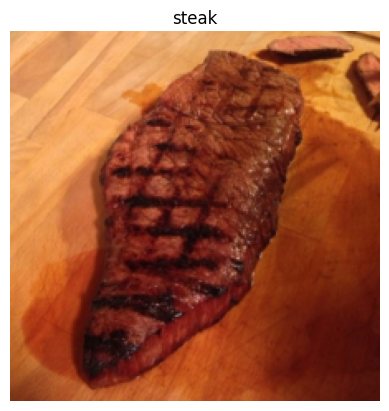

In [11]:
plt.imshow(image.permute(1, 2, 0))
plt.title(class_names[label])
plt.axis('off')
plt.show()

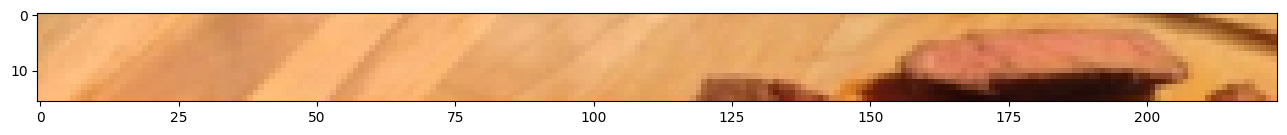

In [12]:
# Change image shape to be compatible with matplotlib (color_channels, height, width) -> (height, width, color_channels)
image_permuted = image.permute(1, 2, 0)

# get the top row of the image
patch_size = 16
plt.figure(figsize=(patch_size, patch_size))
plt.imshow(image_permuted[:patch_size, :, :])

Number of patches per row: 14.0
Patch size: 16 pixels x 16 pixels


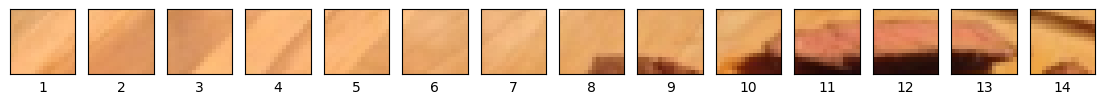

In [13]:
#  turn it into patches
# Setup hyperparameters and make sure img_size and patch_size are compatible
img_size = 224
patch_size = 16
num_patches = img_size/ patch_size
assert img_size % patch_size == 0, 'Image size must be divisible by patch size'
print(f"Number of patches per row: {num_patches}\nPatch size: {patch_size} pixels x {patch_size} pixels")

# create a series of subplots
fig, axs = plt.subplots(nrows=1,
                        ncols=img_size // patch_size, # one column for each patch
                        sharex=True,
                        sharey=True,
                        figsize=(num_patches, num_patches))

# Iterate through number of patches in the top row
for i, patch in enumerate(range(0, img_size, patch_size)):
    axs[i].imshow(image_permuted[:patch_size, patch:patch+patch_size, :]); # 0, 0+16, 16+16, 32+16 ...
    axs[i].set_xlabel(i+1) # set the patch label
    axs[i].set_xticks([]) # 分別隱藏橫軸和縱軸的刻度
    axs[i].set_yticks([]) # 分別隱藏橫軸和縱軸的刻度

Number of patches per row: 14.0        
Number of patches per column: 14.0        
Total patches: 196.0        
Patch size: 16 pixels x 16 pixels


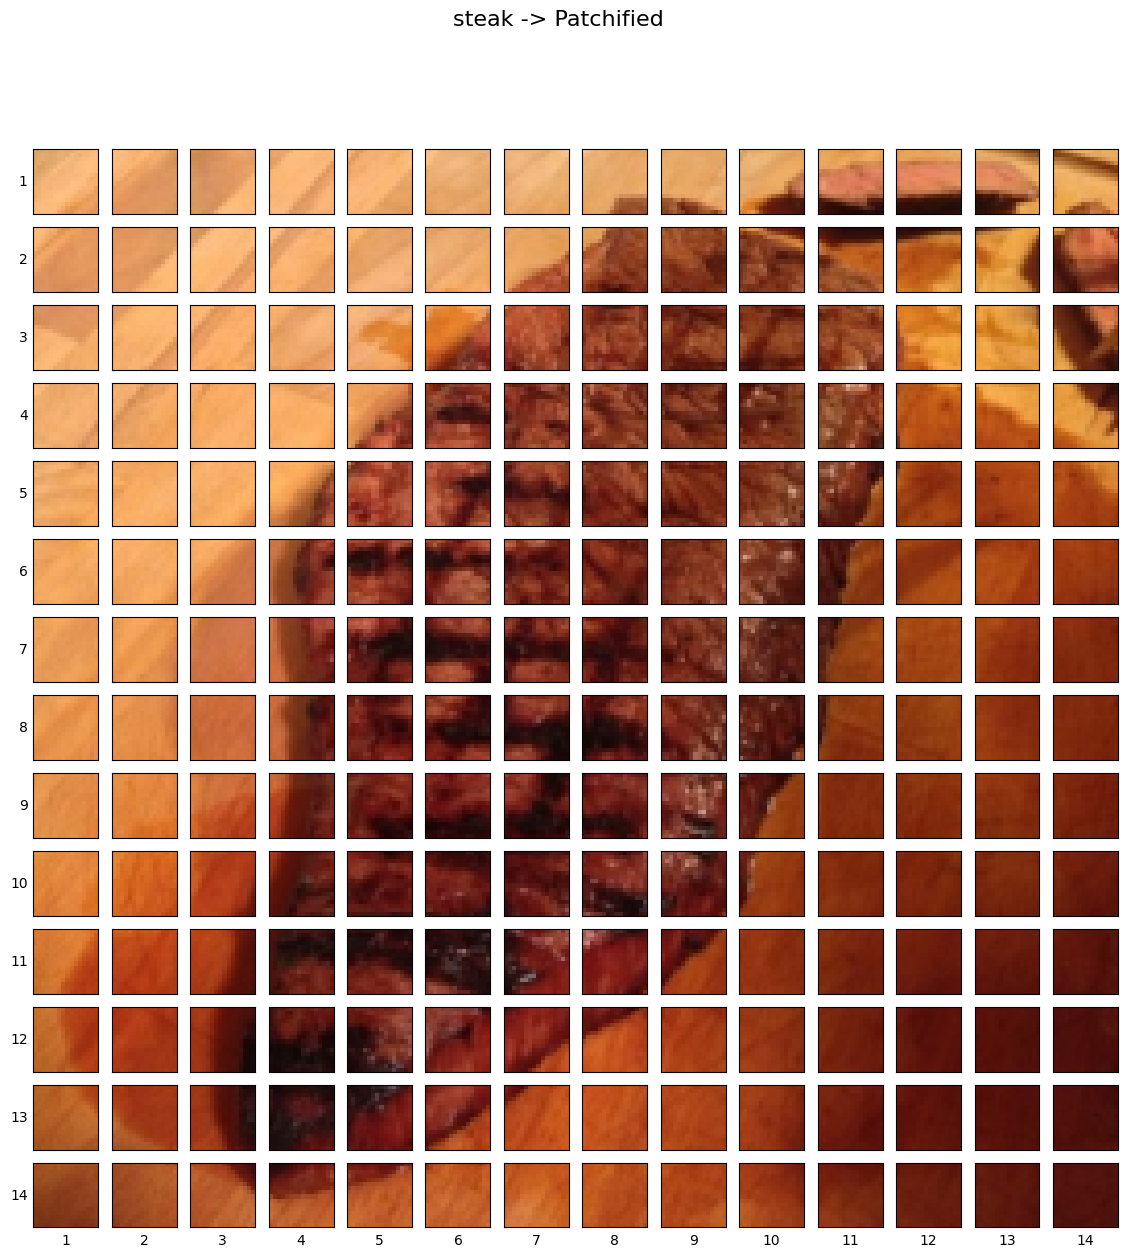

In [14]:
#  turn whole images into patches
img_size = 224
patch_size = 16
num_patches = img_size/ patch_size
assert img_size % patch_size == 0, "Image size must be divisible by patch size"
print(f"Number of patches per row: {num_patches}\
        \nNumber of patches per column: {num_patches}\
        \nTotal patches: {num_patches*num_patches}\
        \nPatch size: {patch_size} pixels x {patch_size} pixels")

# Create series of subplots
fig, axs = plt.subplots(nrows=img_size // patch_size,
                        ncols=img_size // patch_size,
                        figsize=(num_patches, num_patches),
                        sharex=True,
                        sharey=True)

# loop through heightm width of image
for i, patch_height in enumerate(range(0, img_size, patch_size)):
    for j, patch_width in enumerate(range(0, img_size, patch_size)):

        # plot the permuted image on different axis
        axs[i, j].imshow(image_permuted[patch_height:patch_height+patch_size, # height
                                        patch_width:patch_width+patch_size, # width
                                        :]) # get all color channels

        # Set up label information, remove the ticks for clarity and set labels to outside
        axs[i, j].set_ylabel(i+1,
                             rotation="horizontal",
                             horizontalalignment="right",
                             verticalalignment="center")

        axs[i, j].set_xlabel(j+1)
        axs[i, j].set_xticks([])
        axs[i, j].set_yticks([])
        axs[i, j].label_outer()

# Set a super title
fig.suptitle(f"{class_names[label]} -> Patchified", fontsize=16)
plt.show()

## Creating image patches with `torch.nn.Conv2d()` for patch embedding

for an image size of 224 and patch size of 16:

* Input (2D image): (224, 224, 3) -> (height, width, color channels)
* Output (flattened 2D patches): (196, 768) -> (number of patches, embedding dimension)

* `torch.nn.Conv2d()` for turning our image into patches of CNN feature maps.
* `torch.nn.Flatten()` for flattening the spatial dimensions of the feature map.

We can replicate the creation of patches by setting the **kernel_size and stride equal to patch_size**

In [15]:
from torch import nn

patch_size = 16

# Create the Conv2d layer with hyperparameters from the ViT paper
conv2d = nn.Conv2d(in_channels=3, # number of color channels
                   out_channels=768, # from Table 1: Hidden size D, this is the embedding size
                   kernel_size=patch_size,
                   stride=patch_size,
                   padding=0)

conv2d

Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))

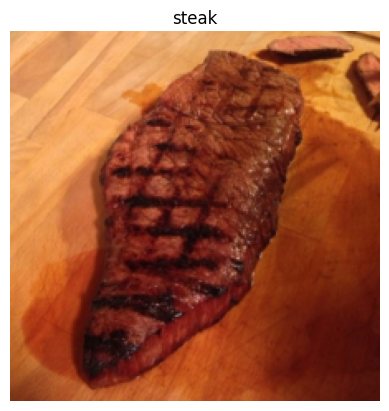

In [16]:
# View single image
plt.imshow(image.permute(1, 2, 0))
plt.title(class_names[label])
plt.axis('off')
plt.show()

In [17]:
# pass the image through the convolutional layer
image_out_of_conv = conv2d(image.unsqueeze(0)) # pytorch model need the batch_size, (batch, height, width, color_channels)
print(image_out_of_conv.shape)
print(image_out_of_conv.shape)

torch.Size([1, 768, 14, 14])
torch.Size([1, 768, 14, 14])


### Passing our image through the convolutional layer turns it into a series of 768 (this is the embedding size or $D$) feature/activation maps.

* So its output shape can be read as:

* torch.Size([1, 768, 14, 14]) -> [batch_size, embedding_dim, feature_map_height, feature_map_width]

Showing random convolutional feature maps from indexes: [662, 649, 749, 719, 279]


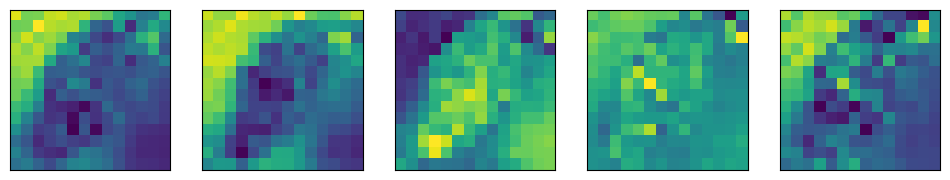

In [18]:
# plot random convolutional feature maps (embeddings)
import random
random_indexes = random.sample(range(0, 758), k=5)
print(f'Showing random convolutional feature maps from indexes: {random_indexes}')

# Create plot
fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(12, 12))

# plot random image feature map
for i, idx in enumerate(random_indexes):
    image_conv_feature_map = image_out_of_conv[:, idx, :, :] # index on the output tensor of the convolutional layer, only select 5 pictures
    axs[i].imshow(image_conv_feature_map.squeeze().detach().numpy())
    axs[i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])


In [19]:
# get a single feature map in tensor form
single_feature_map = image_out_of_conv[:, 0, :, :]
single_feature_map, single_feature_map.requires_grad

(tensor([[[0.4431, 0.3969, 0.3721, 0.4127, 0.4365, 0.4138, 0.4277, 0.4193,
           0.2976, 0.2957, 0.2108, 0.2592, 0.3316, 0.3141],
          [0.3846, 0.3885, 0.4514, 0.4001, 0.4277, 0.4311, 0.3250, 0.1633,
           0.1857, 0.1390, 0.2894, 0.2471, 0.2845, 0.2001],
          [0.4067, 0.4346, 0.4139, 0.4052, 0.3884, 0.1855, 0.2255, 0.1938,
           0.1525, 0.1904, 0.2718, 0.2871, 0.2898, 0.0804],
          [0.4332, 0.4092, 0.3977, 0.4512, 0.2863, 0.1904, 0.2118, 0.1463,
           0.1703, 0.1903, 0.2014, 0.2304, 0.2753, 0.3266],
          [0.4157, 0.4103, 0.4344, 0.2770, 0.2475, 0.1063, 0.1162, 0.1979,
           0.1855, 0.2324, 0.1780, 0.1948, 0.1827, 0.1942],
          [0.4046, 0.4246, 0.3391, 0.1499, 0.1208, 0.1463, 0.0836, 0.1186,
           0.1610, 0.1758, 0.1556, 0.2181, 0.2362, 0.1727],
          [0.3867, 0.3990, 0.3282, 0.1245, 0.0011, 0.0923, 0.1313, 0.0892,
           0.1915, 0.1343, 0.2007, 0.2002, 0.1745, 0.1578],
          [0.3859, 0.3518, 0.2977, 0.1441, 0.1295, 0.08

## Flattening the patch embedding with `torch.nn.Flatten()`

* turned image into patch embeddings but they're still in 2D format.

* need to get flatten, eg: 14*14=196

* 在使用 `torch.nn.Conv2d()` 創建圖像小塊後，**展平操作是將每個小塊轉換為一維向量**，使它們可以作為輸入送入嵌入層或後續的神經網絡層。展平(height, width)

* 這個步驟的核心目的是將圖像的空間信息轉換為一個向量表示，從而可以進一步進行特徵提取和處理。

In [20]:
# Current tensor shape
print(f"Current tensor shape: {image_out_of_conv.shape} -> [batch, embedding_dim, feature_map_height, feature_map_width]")

Current tensor shape: torch.Size([1, 768, 14, 14]) -> [batch, embedding_dim, feature_map_height, feature_map_width]


In [21]:
# Create flatten layer
# [batch, embedding_dim, feature_map_height * feature_map_width], index=2,3 is height, width
# 特徵圖的高度和寬度這兩個維度合併成一個一維向量。
flatten = nn.Flatten(start_dim=2, end_dim=3) # 展平結果 [batch, embedding_dim, feature_map_height * feature_map_width]

1. Take a single image.
2. Put in through the convolutional layer (conv2d) to turn the image into 2D feature maps (patch embeddings).
3. Flatten the 2D feature map into a single sequence.

Original image shape torch.Size([3, 224, 224])
Image feature map shape torch.Size([1, 768, 14, 14])
Flattened image feature map shape torch.Size([1, 768, 196])


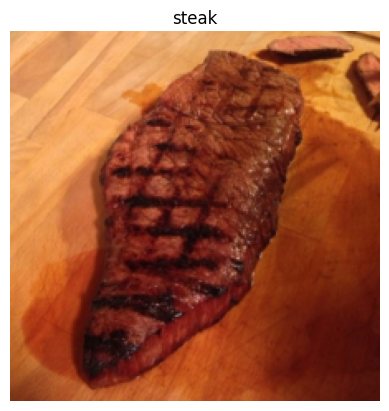

In [22]:
# view single image
plt.imshow(image.permute(1, 2, 0))
plt.title(class_names[label])
plt.axis('off')
print(f'Original image shape {image.shape}')

# turn image into feature maps
image_out_of_conv = conv2d(image.unsqueeze(0))
print(f'Image feature map shape {image_out_of_conv.shape}')

# flatten the features map
image_out_of_conv_flattened = flatten(image_out_of_conv)
print(f'Flattened image feature map shape {image_out_of_conv_flattened.shape}')

* Desired output (flattened 2D patches): (196, 768) -> $N$ x ($P$^2 x $C$)
* Current shape: (1, 768, 196)
* Inorder to fit in transformer

In [23]:
# get flattened image patch embeddings in right shape
image_out_of_conv_flattened_reshaped = image_out_of_conv_flattened.permute(0, 2, 1) # [batch_size, P^2•C, N] -> [batch_size, N, P^2•C]
print(f"Patch embedding sequence shape: {image_out_of_conv_flattened_reshaped.shape} -> [batch_size, num_patches, embedding_size]")

Patch embedding sequence shape: torch.Size([1, 196, 768]) -> [batch_size, num_patches, embedding_size]


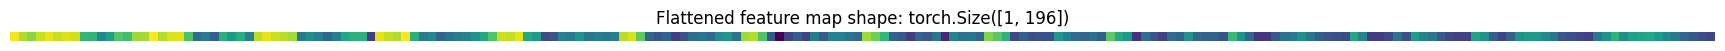

In [24]:
# Get a single flattened feature map
single_flattened_feature_map = image_out_of_conv_flattened_reshaped[:, :, 0] # index: (batch_size, number_of_patches, embedding_dimension)

# plot the flatten feature map
plt.figure(figsize=(22, 22))
plt.imshow(single_flattened_feature_map.detach().numpy())
plt.title(f"Flattened feature map shape: {single_flattened_feature_map.shape}")
plt.axis('off');

## Turning the ViT patch embedding layer into a PyTorch module

1. Create a class called PatchEmbedding which subclasses nn.Module (so it can be used a PyTorch layer).
2. Initialize the class with the parameters in_channels=3, patch_size=16 (for ViT-Base) and embedding_dim=768 (this is
 for ViT-Base from Table 1).
3. Create a layer to turn an image into patches using nn.Conv2d() (just like in 4.3 above).
4. Create a layer to flatten the patch feature maps into a single dimension (just like in 4.4 above).
5. Define a forward() method to take an input and pass it through the layers created in 3 and 4.
6. Make sure the output shape reflects the required output shape of the ViT architecture $(N \times (P^2 \cdot C))$

In [25]:
class PatchEmbedding(nn.Module):
    """Turns a 2D input image into a 1D sequence learnable embedding vector

    Args:
        in_channels (int): Number of color channels for the input images. Default to 3
        patch_size (int): Size of patches to convert input image into. Default to 16
        embedding_size (int): Size of embedding to turn image into. Default to 768
    """
    def __init__(self, in_channels=3, patch_size=16, embedding_dim=768):
        super().__init__()

        # Create a layer to turn an image into patches
        self.patcher = nn.Conv2d(in_channels=3,
                                 out_channels=768,
                                 kernel_size=patch_size,
                                 stride=patch_size,
                                 padding=0)

        # Flatten the layer
        self.flatten = nn.Flatten(start_dim=2, end_dim=3) # height * width

    # Define a foeward method to define the forward computation steps
    # forward 用來定義當數據通過模型時應該執行的所有操作。
    def forward(self, x):
        # Create assertion to check that inputs are the correct shape
        # get the last dimension, in this case is width
        # 取決於你要檢查的寬度或高度 因為要檢查是否能整除 如果是Tensorflow 就會是x.shape[2] 因為排序不同
        image_resolution = x.shape[-1]
        assert image_resolution % patch_size == 0,  f"Input image size must be divisble by patch size, image shape: {image_resolution}, patch size: {patch_size}"

        # perform the forward pass
        x_patched = self.patcher(x)
        x_flattened = self.flatten(x_patched)

        # Make sure the output shape has the right order
        # Transformer 模型的輸入要求 [batch_size, sequence_length, embedding_dim], sequence_length在ViT就是num_batches
        return x_flattened.permute(0, 2, 1) # adjust so the embedding is on the final dimension [batch_size, P^2•C, N] -> [batch_size, N, P^2•C]

In [26]:
patchify = PatchEmbedding(in_channels=3,
                          patch_size=16,
                          embedding_dim=768)

# Pass a single image through
print(f"Input image shape: {image.unsqueeze(0).shape}")
patch_embedded_image = patchify(image.unsqueeze(0)) # add an extra batch dimension on the 0th index, otherwise will error
print(f"Output patch embedding shape: {patch_embedded_image.shape}")

Input image shape: torch.Size([1, 3, 224, 224])
Output patch embedding shape: torch.Size([1, 196, 768])


## Creating the class token embedding

### 為什麼需要分類 token？
* 分類任務：在 ViT 中，最終的圖像分類結果是基於這個分類 token 的輸出表示。通過 Transformer 模型中的自注意力機制，這個 token 能夠與所有圖像小塊的嵌入進行交互，學習到圖像的全局信息，這些信息會被用來進行分類。
* 提升模型能力：通過這個分類 token，模型可以更好地學習到不同圖像之間的差異，提升模型在分類任務中的表現。

* 這個步驟創建了一個分類 token，這是一個可學習的嵌入向量，並將其加入到 Transformer 的輸入中。最終，分類 token 的表示將被用來進行圖像的分類任務。

* ViT 運用 learnable class token 學習每個 patch 和目標物的關聯性

`requires_grad=True` 保證這個參數在反向傳播時是可學習的，模型可以通過訓練來更新這個參數。

In [27]:
# get batch size and embedding dimension
batch_size = patch_embedded_image.shape[0]
embedding_dimension = patch_embedded_image.shape[-1]
batch_size, embedding_dimension

(1, 768)

In [28]:
# Create the class token embedding as a learnable parameter that shares the same size as the embedding dimension (D)
class_token = nn.Parameter(torch.ones(batch_size, 1, embedding_dimension), # [batch_size, number_of_tokens, embedding_dimension]
                           requires_grad=True)

class_token.shape

torch.Size([1, 1, 768])

### 為什麼要這樣做？
* 為了形成完整的序列輸入：Transformer 模型處理的是序列數據，分類 token 和圖像小塊嵌入構成了一個完整的序列。這個序列的第一個元素是分類 token，後面跟著每個圖像小塊的嵌入表示。(把class_token放在最前面)
* 確保分類 token 被處理：將分類 token 放在序列的開頭，保證了它能夠與所有的小塊嵌入一起通過 Transformer 模型的自注意力機制進行處理。這樣，分類 token 最終能夠學習到來自整個圖像的全局信息，這對於進行分類非常重要。

* `class_token` 的形狀是 ```[batch_size, 1, embedding_dimension]```，
* `patch_embedded_image 的形狀是` ```[batch_size, num_patches, embedding_dimension]。```
* `dim=1` 表示在第二個維度（num_patches 維度）上拼接，將分類 token 添加到所有小塊嵌入的前面。拼接後的形狀變為 `[batch_size, num_patches + 1, embedding_dimension]`。

In [29]:
# Add the class token embedding to the front of the patch embedding
patch_embedded_image_with_class_embedding = torch.cat((class_token, patch_embedded_image),
                                                       dim=1) # will be (num_batches + 1)

# Print the sequence of patch embeddings with the prepended class token embedding
print(patch_embedded_image_with_class_embedding)
print(f"Sequence of patch embeddings with class token prepended shape: {patch_embedded_image_with_class_embedding.shape} -> [batch_size, number_of_patches, embedding_dimension]")

tensor([[[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
         [ 0.3522,  0.2752,  0.3328,  ...,  0.3033,  0.3449, -0.2462],
         [ 0.2759,  0.3653,  0.3808,  ...,  0.3098,  0.2820, -0.2414],
         ...,
         [ 0.0601,  0.1302,  0.1217,  ...,  0.1732,  0.0861, -0.1161],
         [ 0.0503,  0.1328,  0.1131,  ...,  0.1512,  0.0756, -0.1126],
         [ 0.0458,  0.1126,  0.1044,  ...,  0.1229,  0.0474, -0.0828]]],
       grad_fn=<CatBackward0>)
Sequence of patch embeddings with class token prepended shape: torch.Size([1, 197, 768]) -> [batch_size, number_of_patches, embedding_dimension]


## Creating the position embedding

* Position Embedding 是為了讓 Transformer 模型獲得序列中元素的位置信息，使其能夠識別出序列的順序或空間位置。這在處理文本、圖像等序列數據時非常重要。
* 在 ViT 中，位置嵌入確保了模型在處理圖像小塊時能夠考慮到每個小塊在原始圖像中的位置，使模型能夠學習到圖像的全局結構。

In [30]:
# View the sequence of patch embeddings with the prepended class embedding
patch_embedded_image_with_class_embedding, patch_embedded_image_with_class_embedding.shape

(tensor([[[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
          [ 0.3522,  0.2752,  0.3328,  ...,  0.3033,  0.3449, -0.2462],
          [ 0.2759,  0.3653,  0.3808,  ...,  0.3098,  0.2820, -0.2414],
          ...,
          [ 0.0601,  0.1302,  0.1217,  ...,  0.1732,  0.0861, -0.1161],
          [ 0.0503,  0.1328,  0.1131,  ...,  0.1512,  0.0756, -0.1126],
          [ 0.0458,  0.1126,  0.1044,  ...,  0.1229,  0.0474, -0.0828]]],
        grad_fn=<CatBackward0>),
 torch.Size([1, 197, 768]))

In [31]:
# calculate N (number_of_patches)
number_of_patches = int((height * width) / patch_size**2)

# get the embedding dimension
embedding_dimension = patch_embedded_image_with_class_embedding.shape[-1]

# create the learnable 1D position embedding
position_embedding = nn.Parameter(torch.ones(1, number_of_patches+1, embedding_dimension), requires_grad=True)

# Show the first 10 sequences and 10 position embedding values and check the shape of the position embedding
print(position_embedding[:, :10, :10])
print(f"Position embeddding shape: {position_embedding.shape} -> [batch_size, number_of_patches, embedding_dimension]")

tensor([[[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]], grad_fn=<SliceBackward0>)
Position embeddding shape: torch.Size([1, 197, 768]) -> [batch_size, number_of_patches, embedding_dimension]


* 在 ViT 中，圖像首先被切分為小塊，每個小塊生成一個嵌入向量。然後，我們在序列的最前面加入一個分類 token，並且創建位置嵌入來提供每個小塊的位置信息。
* 這些嵌入和位置信息一起構成了 Transformer 模型的輸入，使模型能夠學習圖像的全局和空間結構，從而進行有效的圖像分類。

In [32]:
# Add the position embedding to the patch and class token embedding
# 將位置嵌入與小塊嵌入和分類 token 結合，使最終的輸入序列既包含圖像內容信息，也包含位置信息。
patch_and_position_embedding = patch_embedded_image_with_class_embedding + position_embedding
print(patch_and_position_embedding)
print(f"Patch embeddings, class token prepended and positional embeddings added shape: {patch_and_position_embedding.shape} -> [batch_size, number_of_patches, embedding_dimension]")

tensor([[[2.0000, 2.0000, 2.0000,  ..., 2.0000, 2.0000, 2.0000],
         [1.3522, 1.2752, 1.3328,  ..., 1.3033, 1.3449, 0.7538],
         [1.2759, 1.3653, 1.3808,  ..., 1.3098, 1.2820, 0.7586],
         ...,
         [1.0601, 1.1302, 1.1217,  ..., 1.1732, 1.0861, 0.8839],
         [1.0503, 1.1328, 1.1131,  ..., 1.1512, 1.0756, 0.8874],
         [1.0458, 1.1126, 1.1044,  ..., 1.1229, 1.0474, 0.9172]]],
       grad_fn=<AddBackward0>)
Patch embeddings, class token prepended and positional embeddings added shape: torch.Size([1, 197, 768]) -> [batch_size, number_of_patches, embedding_dimension]


##  Putting it all together: from image to embedding

1. Setting the patch size (we'll use 16 as it's widely used throughout the paper and for ViT-Base).
2. Getting a single image, printing its shape and storing its height and width.
3. Adding a batch dimension to the single image so it's compatible with our PatchEmbedding layer.
4. Creating a PatchEmbedding layer with a patch_size=16 and embedding_dim=768 (from Table 1 for ViT-Base).
5. Passing the single image through the PatchEmbedding layer in 4 to create a sequence of patch embeddings.
6. Creating a class token embedding like in section.
7. Prepending the class token embedding to the patch embeddings created in step 5.
8. Creating a position embedding like in section.
9. Adding the position embedding to the class token and patch embeddings created in step 7.


1. 設定小塊大小（我們將使用 16，因為它在論文中和 ViT-Base 模型中被廣泛使用）。
2.  獲取單張圖像，打印其形狀，並存儲其高度和寬度。
3. 為單張圖像添加一個批次維度，使其與我們的 PatchEmbedding 層兼容。
4.  創建一個 PatchEmbedding 層並設置 `patch_size=16` 和 `embedding_dim=768`（根據 ViT-Base 的表 1）。
5.  將單張圖像傳遞通過第 4 步中的 PatchEmbedding 層，創建一個小塊嵌入的序列。
6.  創建一個分類 token 嵌入，如第 4.6 節所述。
7.  將分類 token 嵌入添加到第 5 步創建的小塊嵌入序列的最前面。
8.  創建一個位置嵌入。
9.  將位置嵌入添加到第 7 步創建的分類 token 和小塊嵌入中。


In [33]:
# 1. set the patch size
patch_size = 16

# 2 Print shapes of the original image tensor and get the image dimension
print(f'Image tensor shape: {image.shape}')
height, width = image.shape[1], image.shape[2]

# 3. get image tensor and add a batch dimension
x = image.unsqueeze(0)
print(f"Input image with batch dimension shape: {x.shape}")

# 4. Create patch embedding layer
patch_embedding_layer = PatchEmbedding(in_channels=3,
                                       patch_size=patch_size,
                                       embedding_dim=768)

# 5. Pass image through patch embedding layer
patch_embedding = patch_embedding_layer(x)
print(f"Patching embedding shape: {patch_embedding.shape}")

# 6. Create class token embedding
batch_size = patch_embedding.shape[0]
embedding_dimension = patch_embedding.shape[-1]
class_token = nn.Parameter(torch.ones(batch_size, 1, embedding_dimension),
                           requires_grad=True)
print(f"Class token embedding shape: {class_token.shape}")

# 7. Prepend class token embedding to patch embedding
patch_embedding_class_token = torch.cat((class_token, patch_embedding), dim=1)
print(f"Patch embedding with class token shape: {patch_embedding_class_token.shape}")

# 8. Create position embedding
# 當有一個 shape 為 (1, number_of_patches+1, embedding_dimension) 的張量，它可以被自動廣播到任何 batch size。
number_of_batches = int((height * width) / patch_size**2)
position_embedding = nn.Parameter(torch.ones(1, number_of_patches+1, embedding_dimension),
                                  requires_grad=True)

# 9. Add position embedding to patch embedding with class token
patch_and_position_embedding = patch_embedding_class_token + position_embedding
print(f"Patch and position embedding shape: {patch_and_position_embedding.shape}")

Image tensor shape: torch.Size([3, 224, 224])
Input image with batch dimension shape: torch.Size([1, 3, 224, 224])
Patching embedding shape: torch.Size([1, 196, 768])
Class token embedding shape: torch.Size([1, 1, 768])
Patch embedding with class token shape: torch.Size([1, 197, 768])
Patch and position embedding shape: torch.Size([1, 197, 768])


##  Create Multi-Head Attention (MSA)

* 規範化輸入數據：
LayerNorm 層的目的是對輸入數據進行規範化。這有助於：
改善訓練時間
提高模型的泛化能力（適應未見過的數據的能力）
使不同數據樣本的分佈更加相似，便於模型學習

* 計算自注意力：
MSA 層的主要目的是計算圖像不同部分之間的關係。具體來說：
它計算哪個圖像塊與其他圖像塊最相關
形成圖像的學習表示
這個過程是自動進行的，模型自己學習應該關注的模式

* 結合位置信息：
MSA 層會使用包含位置嵌入的輸入，這確保了模型能夠理解圖像塊的相對位置
實現多頭注意力機制：
通過使用多個注意力頭，模型能夠同時關注不同的特徵和模式
創建殘差連接：
通過將輸入加到層的輸出上，形成殘差連接。這有助於：
緩解梯度消失問題
允許信息更容易地在網絡中流動

* 組合成完整的 Transformer 編碼器塊：
這些層合在一起形成了 Transformer 編碼器的核心部分，使模型能夠有效地處理和理解圖像數據

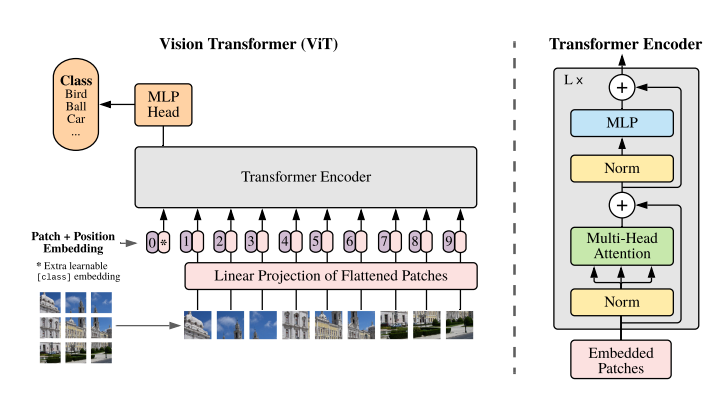

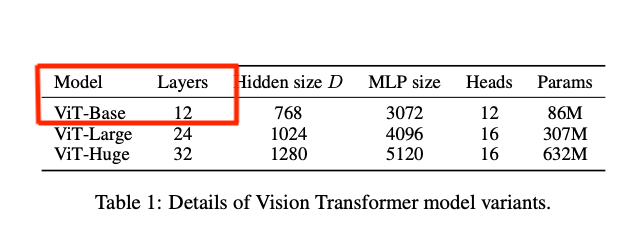

* **query**: 每個輸入位置（如一個詞或一個圖像塊）的表示，用來查詢與其他位置的相關性。
* **key**: 提供所有位置的鍵，幫助 query 查找到最相關的位置。
* **value**: 是我們根據 query 和 key 的相關性來加權平均的對象，最終通過加權的

In [34]:
class MultiheadSelfAttentionBlock(nn.Module):

    # initialize the class with hyperparameters
    def __init__(self,
                 embedding_dim=768,
                 num_heads=12, # the paper suggestion for VitBase
                 attn_dropout=0): # doesn't look like the paper uses any dropout in MSABlocks
        super().__init__()

        # create the Norm layer
        self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)

        # create the multi-head attention layer
        self.multihead_attn = nn.MultiheadAttention(embed_dim=embedding_dim,
                                                    num_heads=num_heads,
                                                    dropout=attn_dropout,
                                                    batch_first=True)


    def forward(self, x):
        x = self.layer_norm(x)
        attn_output, _ = self.multihead_attn(query=x, # _ 因第二個返回值（這裡被忽略）通常是注意力權重。
                                             key=x,
                                             value=x,
                                             need_weights=False)

        return attn_output

In [35]:
# Create an instance of MSABlock
multihead_self_attention_block = MultiheadSelfAttentionBlock(embedding_dim=768, num_heads=12)

# Pass patch and position image embedding through MSABlock
patched_image_through_msa_block = multihead_self_attention_block(patch_and_position_embedding)
print(f"Input shape of MSA block: {patch_and_position_embedding.shape}")
print(f"Output shape MSA block: {patched_image_through_msa_block.shape}")

Input shape of MSA block: torch.Size([1, 197, 768])
Output shape MSA block: torch.Size([1, 197, 768])


## Create Multilayer Perceptron (MLP) 多層感知器

### 目的：
* **非線性變換**：
MLP 引入非線性，使模型能夠學習更複雜的特徵和模式。
這種非線性使 Transformer 能夠捕捉數據中的複雜關係，而不僅僅是線性關係。

* **特徵轉換**：
MLP 將注意力機制的輸出轉換到另一個特徵空間。
這種轉換可以看作是對特徵的進一步處理和精煉。

* **增加模型容量**：
通過添加 MLP，模型的參數數量和學習能力都得到了增加。
這使得模型能夠表示更複雜的函數，從而提高其整體性能。

* **信息整合**：
MLP 幫助整合從多頭注意力機制中學到的信息。
它可以被視為對注意力輸出的"總結"或"提煉"。

* **維度調整**：
在 ViT 中，MLP 通常先將維度擴大（例如擴大 4 倍），然後再壓縮回原始維度。
這種設計允許模型在更高維度的空間中進行計算，可能捕捉更豐富的特徵。

* **改善梯度流動**：
與殘差連接結合，MLP 有助於改善深層網絡中的梯度流動。

* **增加模型的深度**：
每個 Transformer 塊中的 MLP 增加了模型的整體深度，有助於學習更抽象的特徵。

* 在 ViT 的結構中，每個 Transformer 編碼器塊都包含一個 MLP，它位於多頭注意力層之後。這種設計使得模型能夠在處理空間關係（通過注意力機制）後，再對特徵進行非線性變換和整合，從而得到更強大的表示能力。

* MLP 在 ViT 中起到了特徵轉換、非線性引入和信息整合的重要作用，是整個架構不可或缺的組成部分。

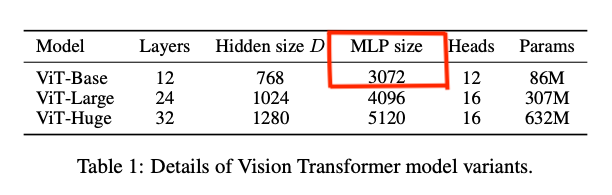

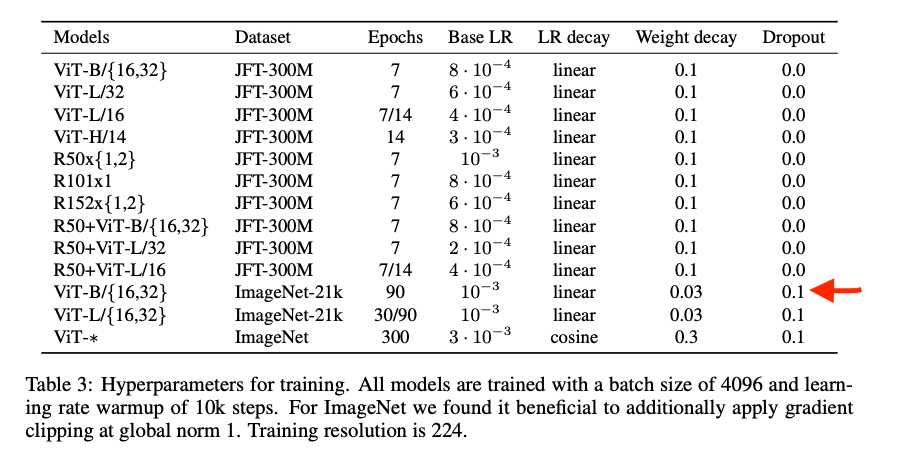

In [36]:
# 整個 MLPBlock 通過標準化輸入，然後通過一個兩層的全連接網絡（帶有非線性激活和 Dropout）處理數據，最終返回與輸入維度相同的輸出
# 第二層主要是線性還原 要與輸入維度保持一致 如果用GELU可能產生的輸出會過於複雜 所以只在第一層線性變換時使用
class MLPBlock(nn.Module):

    def __init__(self,
                 embedding_dim=embedding_dimension,
                 mlp_size=3072,
                 dropout=0.1):
        super().__init__()

        # create the norm layer
        self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)

        # create MLP layer
        self.mlp = nn.Sequential(
            nn.Linear(in_features=embedding_dim,
                      out_features=mlp_size),
            nn.GELU(), # "The MLP contains two layers with a GELU non-linearity
            nn.Dropout(p=dropout),
            nn.Linear(in_features=mlp_size,
                      out_features=embedding_dim), # needs to take same in_features as out_features of layer above
            nn.Dropout(p=dropout)
        )

    def forward(self, x):
        x = self.layer_norm(x)
        x = self.mlp(x)
        return x

In [37]:
mlp_block = MLPBlock(embedding_dim=embedding_dimension,
                     mlp_size=3072,
                     dropout=0.1)

# Pass output of MSABlock to MLPBlock
patched_image_through_mlp_block = mlp_block(patched_image_through_msa_block)
print(f"Input shape of MLP block: {patched_image_through_msa_block.shape}")
print(f"Output shape MLP block: {patched_image_through_mlp_block.shape}")

Input shape of MLP block: torch.Size([1, 197, 768])
Output shape MLP block: torch.Size([1, 197, 768])


## Create the Transformer Encoder

* Encoder = turn a sequence into learnable repressentation
* Decoder = go from learn repressentation back to some sort of sequence
* **Residual connenctions** = add a layer(s) input to its subsequent output, this enables the creation of deeper networks(prevent weights from getting too small)
    * 每個主要塊（MSA 和 MLP）的輸出都與其輸入相加
    * 這意味著每個塊不僅學習新的特徵表示，還保留了來自前一層的信息


```python
# Transformer Encoder
x_input -> MSA_block -> [MSA_block_output + x_input] -> MLP_block -> [MLP_block_output + MSA_block_output + x_input] -> ...
```

In [38]:
class TransformerEncoderBlock(nn.Module):

    def __init__(self,
                 embedding_dim=embedding_dimension,
                 num_heads=12,
                 mlp_size=3072,
                 mlp_dropout=0.1,
                 attn_dropout=0):
        super().__init__()

        # create MSA block
        self.msa_block = MultiheadSelfAttentionBlock(embedding_dim=embedding_dim,
                                                     num_heads=num_heads,
                                                     attn_dropout=attn_dropout)

        # create MLP block
        self.mlp_block = MLPBlock(embedding_dim=embedding_dim,
                                  mlp_size=mlp_size,
                                  dropout=mlp_dropout)

    # create forward method
    def forward(self, x):

        # create residual connection for MSA block (add the input to the output)
        # 將 MSA 的輸出與原始輸入 x 相加
        x = self.msa_block(x) + x

        # create residual connection for MLP block (add the input to the output)
        # MLP 的輸出與其輸入 x 相加
        x = self.mlp_block(x) + x

        return x

In [39]:
# Create an instance of TransformerEncoderBlock
transformer_encoder_block = TransformerEncoderBlock()

# Print an input and output summary of our Transformer Encoder (uncomment for full output)
summary(model=transformer_encoder_block,
        input_size=(1, 197, 768), # (batch_size, num_patches, embedding_dimension)
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
TransformerEncoderBlock (TransformerEncoderBlock)  [1, 197, 768]        [1, 197, 768]        --                   True
├─MultiheadSelfAttentionBlock (msa_block)          [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                      [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─MultiheadAttention (multihead_attn)         --                   [1, 197, 768]        2,362,368            True
├─MLPBlock (mlp_block)                             [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                      [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─Sequential (mlp)                            [1, 197, 768]        [1, 197, 768]        --                   True
│    │    └─Linear (0)                     

## PyTorch now has in-built Transformer layers as part of `torch.nn`

* PyTorch 提供了一個方便的 `nn.TransformerEncoderLayer`，可以直接創建一個完整的 Transformer 編碼器層

In [40]:
# Create the same as above with torch.nn.TransformerEncoderLayer()
torch_transformer_encoder_layer = nn.TransformerEncoderLayer(d_model=768, # Hidden size D from Table 1 for ViT-Base
                                                             nhead=12, # Heads from Table 1 for ViT-Base
                                                             dim_feedforward=3072, # MLP size from Table 1 for ViT-Base
                                                             dropout=0.1, # Amount of dropout for dense layers from Table 3 for ViT-Base
                                                             activation="gelu", # GELU non-linear activation
                                                             batch_first=True, # Do our batches come first?
                                                             norm_first=True) # Normalize first or after MSA/MLP layers?

torch_transformer_encoder_layer

TransformerEncoderLayer(
  (self_attn): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
  )
  (linear1): Linear(in_features=768, out_features=3072, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (linear2): Linear(in_features=3072, out_features=768, bias=True)
  (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (dropout1): Dropout(p=0.1, inplace=False)
  (dropout2): Dropout(p=0.1, inplace=False)
)

##  Putting it all together to create ViT

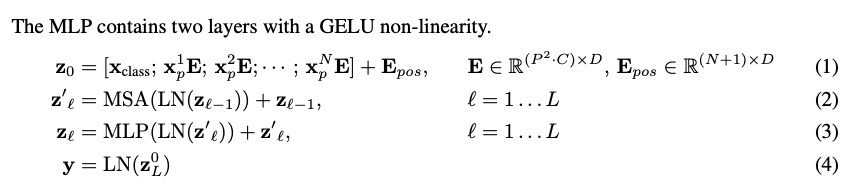

In [41]:
# the args and perameters can refer to the paper
class ViT(nn.Module):

    def __init__(self,
                 img_size=224,
                 in_channels=3,  # Number of channels in input image
                 patch_size=16,
                 num_transformer_layers=12,
                 embedding_dim=768,
                 mlp_size=3072,
                 num_heads=12,
                 attn_dropout=0,
                 mlp_dropout=0.1,
                 embedding_dropout=0.1, # Dropout for patch and position embeddings
                 num_classes=1000): # Default for ImageNet but can customize this
        super().__init__()

        # Make the image size is divisble by the patch size
        assert img_size % patch_size == 0, f"Image size must be divisible by patch size, image size: {img_size}, patch size: {patch_size}."

        # calculate number of patches
        self.num_patches = int((height * width) // patch_size**2)

        # create learnable class embedding (needs to go at front of sequence of patche embeddings)
        # (1, 1, embedding_dim) 的形狀使得類別嵌入可以作為一個可學習的參數，同時保持了靈活性，可以適應不同的批次大小
        # 第一個維度（1）允許批次處理，第二個維度（1）表示它是序列中的一個單獨元素，第三個維度（embedding_dim）保持與模型其他部分的一致性
        self.class_embedding = nn.Parameter(data=torch.randn(1, 1, embedding_dim),
                                            requires_grad=True)

        # create learnable position embedding
        self.position_embedding = nn.Parameter(data=torch.randn(1, self.num_patches+1, embedding_dim),
                                               requires_grad=True)

        # create embedding dropout value
        self.embedding_dropout = nn.Dropout(p=embedding_dropout)

        # create patch embedding layer
        self.patch_embedding = PatchEmbedding(in_channels=in_channels,
                                              patch_size=patch_size,
                                              embedding_dim=embedding_dim)

        # create Transformer Encoder blocks (we can stack Transformer Encoder blocks using nn.Sequential())
        # Note: The "*" means "all"
        self.transformer_encoder = nn.Sequential(*[TransformerEncoderBlock(embedding_dim=embedding_dim,
                                                                           num_heads=num_heads,
                                                                           mlp_size=mlp_size,
                                                                           mlp_dropout=mlp_dropout) for _ in range(num_transformer_layers)])

        # create classifier head
        self.classifier = nn.Sequential(
            nn.LayerNorm(normalized_shape=embedding_dim),
            nn.Linear(in_features=embedding_dim,
                      out_features=num_classes)
        )

    def forward(self, x):

        # 獲取輸入圖像的批次大小。
        batch_size = x.shape[0]

        # Create class token embedding and expand it to match the batch size (equation 1)
        # -1代表維持原樣 結合上面的class_embedding就會變成 [batch_size, 1, embedding_dim]
        # 創建一個分類 token 嵌入，並將其擴展到與批次大小一致
        class_token = self.class_embedding.expand(batch_size, -1, -1)

        # create patch embedding (equation 1)
        # 將輸入圖像分割為小塊（patch），並為每個小塊生成嵌入表示
        x = self.patch_embedding(x)

        # concat class embedding and patch embedding (equation 1)
        # 將分類 token 和 patch 嵌入連接在一起，形成一個包含所有 patch 和分類 token 的序
        x = torch.concat((class_token, x), dim=1)

        # add position embedding to patch embedding (equation 1)
        # 將位置嵌入添加到 patch 和分類 token 的嵌入中，使模型能夠感知每個 patch 的位置
        x = self.position_embedding + x

        # run embedding dropout
        # 在加入位置嵌入之後，應用 dropout 以防止過擬合
        x = self.embedding_dropout(x)

        # pass patch, position and class embedding through transformer encoder layers (equations 2 & 3)
        # 將 patch 和分類 token 嵌入通過多個 Transformer 編碼器層進行處理
        x = self.transformer_encoder(x)

        # put 0 index logit through classifier (equation 4)
        # x[:, 0] 提取序列中的第一個元素（分類 token），其形狀為 [batch_size, embedding_dim]
        # 對序列中的分類 token 進行分類，以生成最終的圖像分類結果
        x = self.classifier(x[:, 0])

        return x

In [42]:
# Example of creating the class embedding and expanding over a batch dimension
batch_size = 32
class_token_embedding_single = nn.Parameter(data=torch.randn(1, 1, 768)) # create a single learnable class token
class_token_embedding_expanded = class_token_embedding_single.expand(batch_size, -1, -1)

# Print out the change in shapes
print(f"Shape of class token embedding single: {class_token_embedding_single.shape}")
print(f"Shape of class token embedding expanded: {class_token_embedding_expanded.shape}")

Shape of class token embedding single: torch.Size([1, 1, 768])
Shape of class token embedding expanded: torch.Size([32, 1, 768])


## Getting a visual summary of our ViT model

In [43]:
# Create a random tensor with same shape as a single image
random_image_tensor = torch.randn(1, 3, 224, 224) # (batch_size, color_channels, height, width)

# Create an instance of ViT with the number of classes we're working with (pizza, steak, sushi)
vit = ViT(num_classes=len(class_names))

# Pass the random image tensor to our ViT instance
vit(random_image_tensor)

tensor([[ 0.8643, -0.4382, -1.1147]], grad_fn=<AddmmBackward0>)

In [44]:
from torchinfo import summary

# Print a summary of our custom ViT model using torchinfo (uncomment for actual output)
summary(model=vit,
        input_size=(32, 3, 224, 224), # (batch_size, color_channels, height, width)
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
ViT (ViT)                                                    [32, 3, 224, 224]    [32, 3]              152,064              True
├─PatchEmbedding (patch_embedding)                           [32, 3, 224, 224]    [32, 196, 768]       --                   True
│    └─Conv2d (patcher)                                      [32, 3, 224, 224]    [32, 768, 14, 14]    590,592              True
│    └─Flatten (flatten)                                     [32, 768, 14, 14]    [32, 768, 196]       --                   --
├─Dropout (embedding_dropout)                                [32, 197, 768]       [32, 197, 768]       --                   --
├─Sequential (transformer_encoder)                           [32, 197, 768]       [32, 197, 768]       --                   True
│    └─TransformerEncoderBlock (0)                           [32, 197, 768]       [32, 197, 768]

##  Setting up training code for ViT model

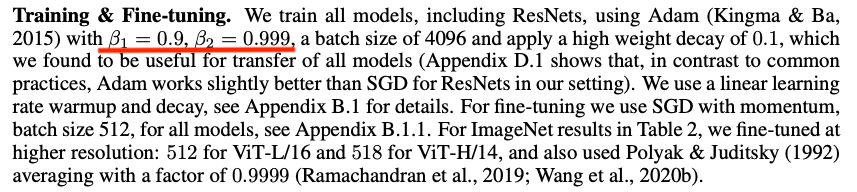

In [46]:
from going_modular.going_modular import engine

optimizer = torch.optim.Adam(params=vit.parameters(),
                             lr=3e-3, # Base LR from Table 3 for ViT-* ImageNet-1k)
                             betas=(0.9, 0.999), # default values but also mentioned in ViT paper section 4.1 (Training & Fine-tuning)
                             weight_decay=0.3) # from the ViT paper section 4.1 (Training & Fine-tuning) and Table 3 for ViT-* ImageNet-1k

loss_fn = nn.CrossEntropyLoss()

results = engine.train(model=vit,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=10,
                       device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.2338 | train_acc: 0.3633 | test_loss: 1.2479 | test_acc: 0.5417
Epoch: 2 | train_loss: 1.2477 | train_acc: 0.3867 | test_loss: 1.7219 | test_acc: 0.2604
Epoch: 3 | train_loss: 1.1806 | train_acc: 0.3047 | test_loss: 1.4558 | test_acc: 0.1979
Epoch: 4 | train_loss: 1.1606 | train_acc: 0.2734 | test_loss: 1.2059 | test_acc: 0.1979
Epoch: 5 | train_loss: 1.1010 | train_acc: 0.4102 | test_loss: 1.4154 | test_acc: 0.2604
Epoch: 6 | train_loss: 1.2332 | train_acc: 0.2891 | test_loss: 1.1782 | test_acc: 0.2604
Epoch: 7 | train_loss: 1.1804 | train_acc: 0.2656 | test_loss: 1.2846 | test_acc: 0.1979
Epoch: 8 | train_loss: 1.1529 | train_acc: 0.2930 | test_loss: 1.3015 | test_acc: 0.2604
Epoch: 9 | train_loss: 1.1694 | train_acc: 0.3047 | test_loss: 1.0285 | test_acc: 0.5417
Epoch: 10 | train_loss: 1.2461 | train_acc: 0.2812 | test_loss: 1.3873 | test_acc: 0.2604


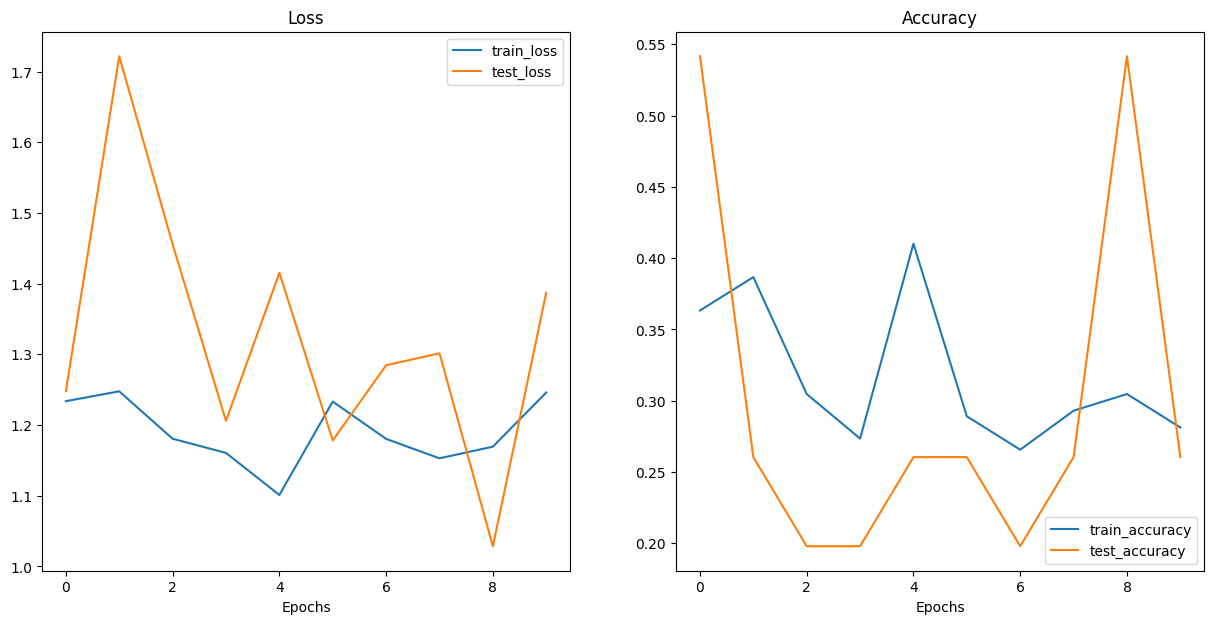

In [47]:
from helper_functions import plot_loss_curves

# Plot our ViT model's loss curves
plot_loss_curves(results)

## Using a pretrained ViT from torchvision.models on the same dataset

* Get a pretrained ViT model from `torchvision.models`.

In [52]:
pretrained_vit_weights = torchvision.models.ViT_B_16_Weights.DEFAULT

# setup VIT model
pretrained_vit = torchvision.models.vit_b_16(weights=pretrained_vit_weights).to(device)

# Freeze the base parameters
for parameter in pretrained_vit.parameters():
    parameter.requires_grad = False

# Update classifier head
pretrained_vit.heads = nn.Linear(in_features=768, out_features=len(class_names)).to(device)

In [53]:
# Print a summary using torchinfo (uncomment for actual output)
summary(model=pretrained_vit,
        input_size=(32, 3, 224, 224), # (batch_size, color_channels, height, width)
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [32, 3, 224, 224]    [32, 3]              768                  Partial
├─Conv2d (conv_proj)                                         [32, 3, 224, 224]    [32, 768, 14, 14]    (590,592)            False
├─Encoder (encoder)                                          [32, 197, 768]       [32, 197, 768]       151,296              False
│    └─Dropout (dropout)                                     [32, 197, 768]       [32, 197, 768]       --                   --
│    └─Sequential (layers)                                   [32, 197, 768]       [32, 197, 768]       --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [32, 197, 768]       [32, 197, 768]       (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [32, 197, 768]       [32, 

## Preparing data for the pretrained ViT model

In [54]:
from helper_functions import download_data

# Download pizza, steak, sushi images from GitHub
image_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                           destination="pizza_steak_sushi")
image_path

[INFO] data/pizza_steak_sushi directory exists, skipping download.


PosixPath('data/pizza_steak_sushi')

In [55]:
train_dir = image_path / 'train'
test_dir = image_path / 'test'

train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

In [56]:
# Get automatic transforms from pretrained ViT weights
pretrained_vit_transforms = pretrained_vit_weights.transforms()
print(pretrained_vit_transforms)

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)


In [58]:
train_dataloader_pretrained, test_dataloader_pretrained, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                                                     test_dir=test_dir,
                                                                                                     transform=pretrained_vit_transforms,
                                                                                                     batch_size=32)

## Train feature extractor ViT model

In [61]:
optimizer = torch.optim.Adam(pretrained_vit.parameters(),
                             lr=1e-3)

loss_fn = nn.CrossEntropyLoss()

pretrained_vit_results = engine.train(model=pretrained_vit,
                                      train_dataloader=train_dataloader_pretrained,
                                      test_dataloader=test_dataloader_pretrained,
                                      optimizer=optimizer,
                                      loss_fn=loss_fn,
                                      epochs=15,
                                      device=device)

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.0689 | train_acc: 0.9844 | test_loss: 0.1844 | test_acc: 0.9280
Epoch: 2 | train_loss: 0.0463 | train_acc: 0.9922 | test_loss: 0.1981 | test_acc: 0.9081
Epoch: 3 | train_loss: 0.0692 | train_acc: 0.9922 | test_loss: 0.1984 | test_acc: 0.9081
Epoch: 4 | train_loss: 0.0313 | train_acc: 0.9961 | test_loss: 0.2168 | test_acc: 0.9081
Epoch: 5 | train_loss: 0.0261 | train_acc: 0.9961 | test_loss: 0.2065 | test_acc: 0.9081
Epoch: 6 | train_loss: 0.0225 | train_acc: 1.0000 | test_loss: 0.1935 | test_acc: 0.8977
Epoch: 7 | train_loss: 0.0207 | train_acc: 1.0000 | test_loss: 0.1858 | test_acc: 0.8977
Epoch: 8 | train_loss: 0.0172 | train_acc: 1.0000 | test_loss: 0.1899 | test_acc: 0.8977
Epoch: 9 | train_loss: 0.0152 | train_acc: 1.0000 | test_loss: 0.1929 | test_acc: 0.8977
Epoch: 10 | train_loss: 0.0295 | train_acc: 1.0000 | test_loss: 0.1976 | test_acc: 0.9081
Epoch: 11 | train_loss: 0.0131 | train_acc: 1.0000 | test_loss: 0.2192 | test_acc: 0.9081
Epoch: 12 | train_l

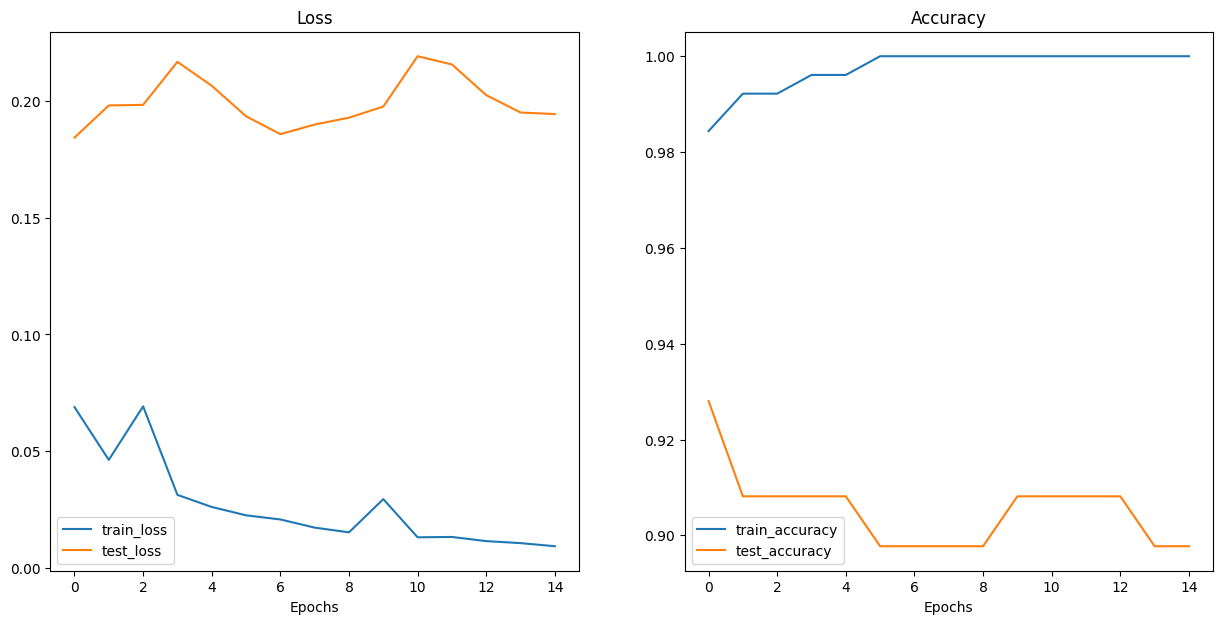

In [62]:
# Plot the loss curves
plot_loss_curves(pretrained_vit_results)

## Save feature extractor ViT model and check file size

In [63]:
# Save the model
from going_modular.going_modular import utils

utils.save_model(model=pretrained_vit,
                 target_dir='models',
                 model_name='Pretrained_VIT_feature_extractor_pizza_steak_sushi.pth')

[INFO] Saving model to: models/Pretrained_VIT_feature_extractor_pizza_steak_sushi.pth


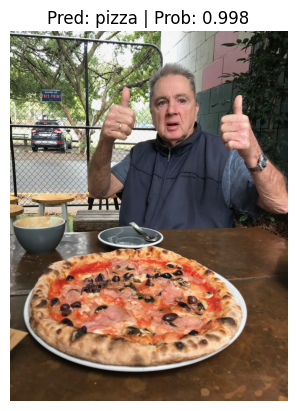

In [66]:
import requests

# Import function to make predictions on images and plot them
from going_modular.going_modular.predictions import pred_and_plot_image

# Setup custom image path
custom_image_path = image_path / "04-pizza-dad.jpeg"

# Download the image if it doesn't already exist
if not custom_image_path.is_file():
    with open(custom_image_path, "wb") as f:
        # When downloading from GitHub, need to use the "raw" file link
        request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg")
        print(f"Downloading {custom_image_path}...")
        f.write(request.content)
else:
    print(f"{custom_image_path} already exists, skipping download.")

# Predict on custom image
pred_and_plot_image(model=pretrained_vit,
                    image_path=custom_image_path,
                    class_names=class_names)